In [1]:
# Install required packages
!pip install -q pydicom scikit-image

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# -------------------------
# 0. Imports & hyperparams
# -------------------------
import os, random, math, time
import numpy as np
import pydicom
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
import matplotlib.pyplot as plt
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# --- Hyperparameters (tweak these) ---
DATA_DIR = "/content/drive/MyDrive/Dataset/Brain Dicom Image"  # <<< SET THIS to your drive folder
IMG_SIZE = 256           # resize images to this (H=W). Lower -> faster.
NUM_CLIENTS = 4
TEST_FRAC = 0.10         # fraction held out as global test
NUM_ROUNDS = 6           # federated rounds
LOCAL_EPOCHS = 1         # local epochs per round
BATCH_SIZE = 8
LR = 1e-3
ACCEL = 4                # acceleration factor for undersampling (e.g., 4x)
CENTER_FRACTION = 0.08   # fraction of center k-space fully sampled
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

print("Device:", DEVICE)

# -------------------------


Device: cpu


In [4]:
# 1. Read DICOMs from Drive
# -------------------------
def read_dicom_image(path):
    ds = pydicom.dcmread(path)
    arr = ds.pixel_array.astype(np.float32)
    # handle photometric interpretations / multi-frame? we assume single 2D frame
    # Normalize to [0,1]
    arr = arr - arr.min()
    mx = arr.max() if arr.max() != 0 else 1.0
    arr = arr / mx
    return arr

# Collect files
files = sorted([f for f in glob(os.path.join(DATA_DIR, "**", "*.dcm"), recursive=True)])
if len(files) == 0:
    raise FileNotFoundError(f"No .dcm files found at {DATA_DIR}. Update DATA_DIR and re-run.")
print(f"Found {len(files)} DICOM files. Loading and resizing to {IMG_SIZE}x{IMG_SIZE}...")

images = []
for f in files:
    img = read_dicom_image(f)
    # resize to consistent shape
    if img.shape != (IMG_SIZE, IMG_SIZE):
        img = resize(img, (IMG_SIZE, IMG_SIZE), anti_aliasing=True)
    images.append(img.astype(np.float32))
images = np.stack(images)  # (N, H, W)
print("Images array shape:", images.shape)

# -------------------------

Found 170 DICOM files. Loading and resizing to 256x256...
Images array shape: (170, 256, 256)


In [5]:
# 2. K-space helpers & mask
# -------------------------
def img2kspace(img):
    # img: 2D numpy real array
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))

def kspace2img(ksp):
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ksp))))

def create_cartesian_mask(shape, accel=4, center_fraction=0.08):
    # shape = (H, W) -> undersample columns (phase-encode direction)
    H, W = shape
    mask = np.zeros(W, dtype=np.float32)
    # center fully sampled
    center = int(round(W * center_fraction))
    cstart = (W - center) // 2
    mask[cstart:cstart + center] = 1
    # outside center, sample every 'accel' column (simple uniform sampling)
    for i in range(W):
        if mask[i] == 0 and (i % accel == 0):
            mask[i] = 1
    mask2d = np.tile(mask, (H, 1))
    return mask2d

# Example mask visualization (optional)
# plt.imshow(create_cartesian_mask((IMG_SIZE, IMG_SIZE), ACCEL, CENTER_FRACTION), cmap='gray'); plt.title("Sampling mask"); plt.show()

# -------------------------

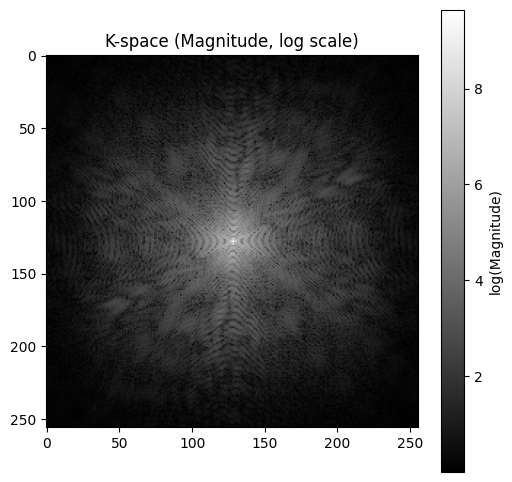

In [6]:
# Visualize k-space of an image
# -------------------------
# Select an image (e.g., the first one)
example_image = images[0]

# Compute its k-space representation
kspace_image = img2kspace(example_image)

# Visualize the magnitude of the k-space (often visualized on a log scale)
plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(kspace_image) + 1), cmap='gray') # Add 1 to avoid log(0)
plt.title("K-space (Magnitude, log scale)")
plt.colorbar(label="log(Magnitude)")
plt.show()

# -------------------------

In [7]:
# 3. Build paired dataset: zero-filled (input) -> ground-truth (target)
# -------------------------
X = []
Y = []
mask = create_cartesian_mask((IMG_SIZE, IMG_SIZE), ACCEL, CENTER_FRACTION)
for img in images:
    ksp = img2kspace(img)
    ksp_u = ksp * mask
    zf = kspace2img(ksp_u)
    # Normalize per-image to [0,1] (keeps stable training)
    y = img / (img.max() + 1e-12)
    x = zf / (zf.max() + 1e-12)
    X.append(x.astype(np.float32))
    Y.append(y.astype(np.float32))
X = np.stack(X)  # (N,H,W)
Y = np.stack(Y)
print("Prepared X,Y shapes:", X.shape, Y.shape)

# -------------------------

Prepared X,Y shapes: (170, 256, 256) (170, 256, 256)


In [8]:
# 4. Train/test split, split clients
# -------------------------
N = X.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

n_test = max(1, int(N * TEST_FRAC))
test_idx = indices[:n_test]
rest_idx = indices[n_test:]

# Split remaining indices into NUM_CLIENTS buckets (clients)
splits = np.array_split(rest_idx, NUM_CLIENTS)
for i, s in enumerate(splits):
    print(f"Client {i}: {len(s)} slices")
print("Test set size:", len(test_idx))

# -------------------------

Client 0: 39 slices
Client 1: 38 slices
Client 2: 38 slices
Client 3: 38 slices
Test set size: 17


In [9]:
# 5. PyTorch Dataset
# -------------------------
class MRIDataset(Dataset):
    def __init__(self, Xarr, Yarr, idx_list):
        self.X = Xarr
        self.Y = Yarr
        self.idx = list(idx_list)
    def __len__(self):
        return len(self.idx)
    def __getitem__(self, i):
        idd = self.idx[i]
        x = torch.from_numpy(self.X[idd]).unsqueeze(0)  # (1,H,W)
        y = torch.from_numpy(self.Y[idd]).unsqueeze(0)
        return x.float(), y.float()

# Example loaders for one client
# client0_loader = DataLoader(MRIDataset(X,Y,splits[0]), batch_size=BATCH_SIZE, shuffle=True)

# -------------------------

In [15]:
# 6. Small U-Net model
# -------------------------
def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
    )

class SimpleUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, features=[32,64,128]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        ch = in_ch
        for f in features:
            self.downs.append(double_conv(ch, f))
            self.pools.append(nn.MaxPool2d(2))
            ch = f
        self.bottleneck = double_conv(ch, ch*2)
        # up
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        rev = list(reversed(features))
        in_up = ch*2
        for f in rev:
            self.ups.append(nn.ConvTranspose2d(in_up, f, kernel_size=2, stride=2))
            self.up_convs.append(double_conv(in_up, f))
            in_up = f
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down, pool in zip(self.downs, self.pools):
            x = down(x)
            skip_connections.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, conv in zip(self.ups, self.up_convs):
            x = up(x)
            skip = skip_connections.pop()
            # in case sizes mismatch due to odd dims, center-crop skip
            if x.shape != skip.shape:
                # center crop
                _,_,h,w = x.shape
                skip = skip[:,:, :h, :w]
            x = torch.cat([skip, x], dim=1)
            x = conv(x)
        x = self.final_conv(x)

        return x

# -------------------------

In [16]:
# 7. Utility: convert state_dict <-> numpy
# -------------------------
def state_dict_to_numpy(state_dict):
    return {k: v.cpu().numpy() for k,v in state_dict.items()}

def numpy_to_state_dict(np_dict, template_state_dict):
    # template for dtype/shape
    out = {}
    for k, v in template_state_dict.items():
        out[k] = torch.tensor(np_dict[k], dtype=v.dtype)
    return out

def average_state_dicts(state_dicts, weights):
    # state_dicts: list of dicts {key: np.array}
    keys = list(state_dicts[0].keys())
    total = float(sum(weights))
    avg = {}
    for k in keys:
        stacked = np.stack([sd[k].astype(np.float32) * (weights[i] / total) for i, sd in enumerate(state_dicts)], axis=0)
        avg[k] = np.sum(stacked, axis=0)
    return avg

# -------------------------

In [17]:
# 8. Local training function for a client
# -------------------------
NUM_ROUNDS = 20
LOCAL_EPOCHS = 3
LR = 1e-4   # slightly smaller learning rate
def train_local(model, train_loader, epochs, device, lr=LR):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    model.train()
    for epoch in range(epochs):
        running = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
    return model

def evaluate_model(model, loader, device):
    model.to(device)
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    total_loss = 0.0
    all_psnr = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total_loss += loss.item() * xb.size(0)
            # compute PSNR per slice (convert to numpy)
            p_np = pred.cpu().numpy()
            y_np = yb.cpu().numpy()
            for i in range(p_np.shape[0]):
                psnr = compute_psnr(y_np[i,0], p_np[i,0], data_range=1.0)
                all_psnr.append(psnr)
    avg_loss = total_loss / (len(loader.dataset))
    avg_psnr = float(np.mean(all_psnr)) if len(all_psnr) > 0 else 0.0
    return avg_loss, avg_psnr
xb, yb = next(iter(test_loader))
xb = xb.to(DEVICE)
with torch.no_grad():
    pred = global_model(xb)
print("Prediction stats:", pred.min().item(), pred.max().item())
# -------------------------

Prediction stats: 0.0 0.0


In [18]:
# 9. Federated (FedAvg) simulation loop
# -------------------------
global_model = SimpleUNet().to(DEVICE)
global_state = state_dict_to_numpy(global_model.state_dict())

# Prepare per-client DataLoaders
client_loaders = []
client_val_loaders = []
client_sizes = []
for client_idx in range(NUM_CLIENTS):
    idxs = splits[client_idx]
    if len(idxs) == 0:
        client_loaders.append(None); client_val_loaders.append(None); client_sizes.append(0)
        continue
    # split client data into local train/val (80/20)
    n = len(idxs)
    cut = max(1, int(0.8 * n))
    tr_idx = idxs[:cut]
    val_idx = idxs[cut:] if cut < n else idxs[:1]  # at least 1 val if possible
    tr_loader = DataLoader(MRIDataset(X, Y, tr_idx), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MRIDataset(X, Y, val_idx), batch_size=BATCH_SIZE, shuffle=False)
    client_loaders.append(tr_loader)
    client_val_loaders.append(val_loader)
    client_sizes.append(len(tr_loader.dataset))

# Create a test loader
test_loader = DataLoader(MRIDataset(X, Y, test_idx), batch_size=BATCH_SIZE, shuffle=False)

print("Starting FedAvg simulation:")
for rnd in range(1, NUM_ROUNDS + 1):
    t0 = time.time()
    local_states = []
    local_weights = []
    print(f"\nRound {rnd}/{NUM_ROUNDS} - Global model -> distribute to clients")
    for cid in range(NUM_CLIENTS):
        if client_loaders[cid] is None or client_sizes[cid] == 0:
            print(f" - Client {cid} has no data, skipping.")
            continue
        # create a fresh local model and load global params
        local_model = SimpleUNet().to(DEVICE)
        # set params
        template = local_model.state_dict()
        local_model.load_state_dict(numpy_to_state_dict(global_state, template))
        # local training
        local_model = train_local(local_model, client_loaders[cid], LOCAL_EPOCHS, DEVICE, lr=LR)
        # append state dict (numpy) and weight (num samples)
        local_states.append(state_dict_to_numpy(local_model.state_dict()))
        local_weights.append(client_sizes[cid])
        print(f"  - Client {cid} trained on {client_sizes[cid]} samples")
    # aggregate
    if len(local_states) == 0:
        raise RuntimeError("No clients trained -- check data splits.")
    avg_state = average_state_dicts(local_states, local_weights)
    # set global_state
    global_state = avg_state
    global_model.load_state_dict(numpy_to_state_dict(global_state, global_model.state_dict()))
    # Evaluate global model on test set & on each client's val set
    test_loss, test_psnr = evaluate_model(global_model, test_loader, DEVICE)
    print(f"Round {rnd} finished in {time.time()-t0:.1f}s -- Test MSE: {test_loss:.6f}, Test PSNR: {test_psnr:.2f} dB")
    # optional: per-client val metrics
    for cid in range(NUM_CLIENTS):
        if client_val_loaders[cid] is None: continue
        vl, vp = evaluate_model(global_model, client_val_loaders[cid], DEVICE)
        print(f"   client {cid} val PSNR: {vp:.2f} (val size {len(client_val_loaders[cid].dataset)})")

# -------------------------

Starting FedAvg simulation:

Round 1/20 - Global model -> distribute to clients
  - Client 0 trained on 31 samples
  - Client 1 trained on 30 samples
  - Client 2 trained on 30 samples
  - Client 3 trained on 30 samples
Round 1 finished in 643.8s -- Test MSE: 0.037811, Test PSNR: 14.42 dB
   client 0 val PSNR: 13.98 (val size 8)
   client 1 val PSNR: 14.17 (val size 8)
   client 2 val PSNR: 14.95 (val size 8)
   client 3 val PSNR: 15.16 (val size 8)

Round 2/20 - Global model -> distribute to clients
  - Client 0 trained on 31 samples
  - Client 1 trained on 30 samples
  - Client 2 trained on 30 samples
  - Client 3 trained on 30 samples
Round 2 finished in 635.4s -- Test MSE: 0.029123, Test PSNR: 15.58 dB
   client 0 val PSNR: 15.08 (val size 8)
   client 1 val PSNR: 15.30 (val size 8)
   client 2 val PSNR: 16.06 (val size 8)
   client 3 val PSNR: 16.28 (val size 8)

Round 3/20 - Global model -> distribute to clients
  - Client 0 trained on 31 samples
  - Client 1 trained on 30 sample


Final evaluation on held-out test set:
 Final Test MSE: 0.003336, PSNR: 26.97 dB


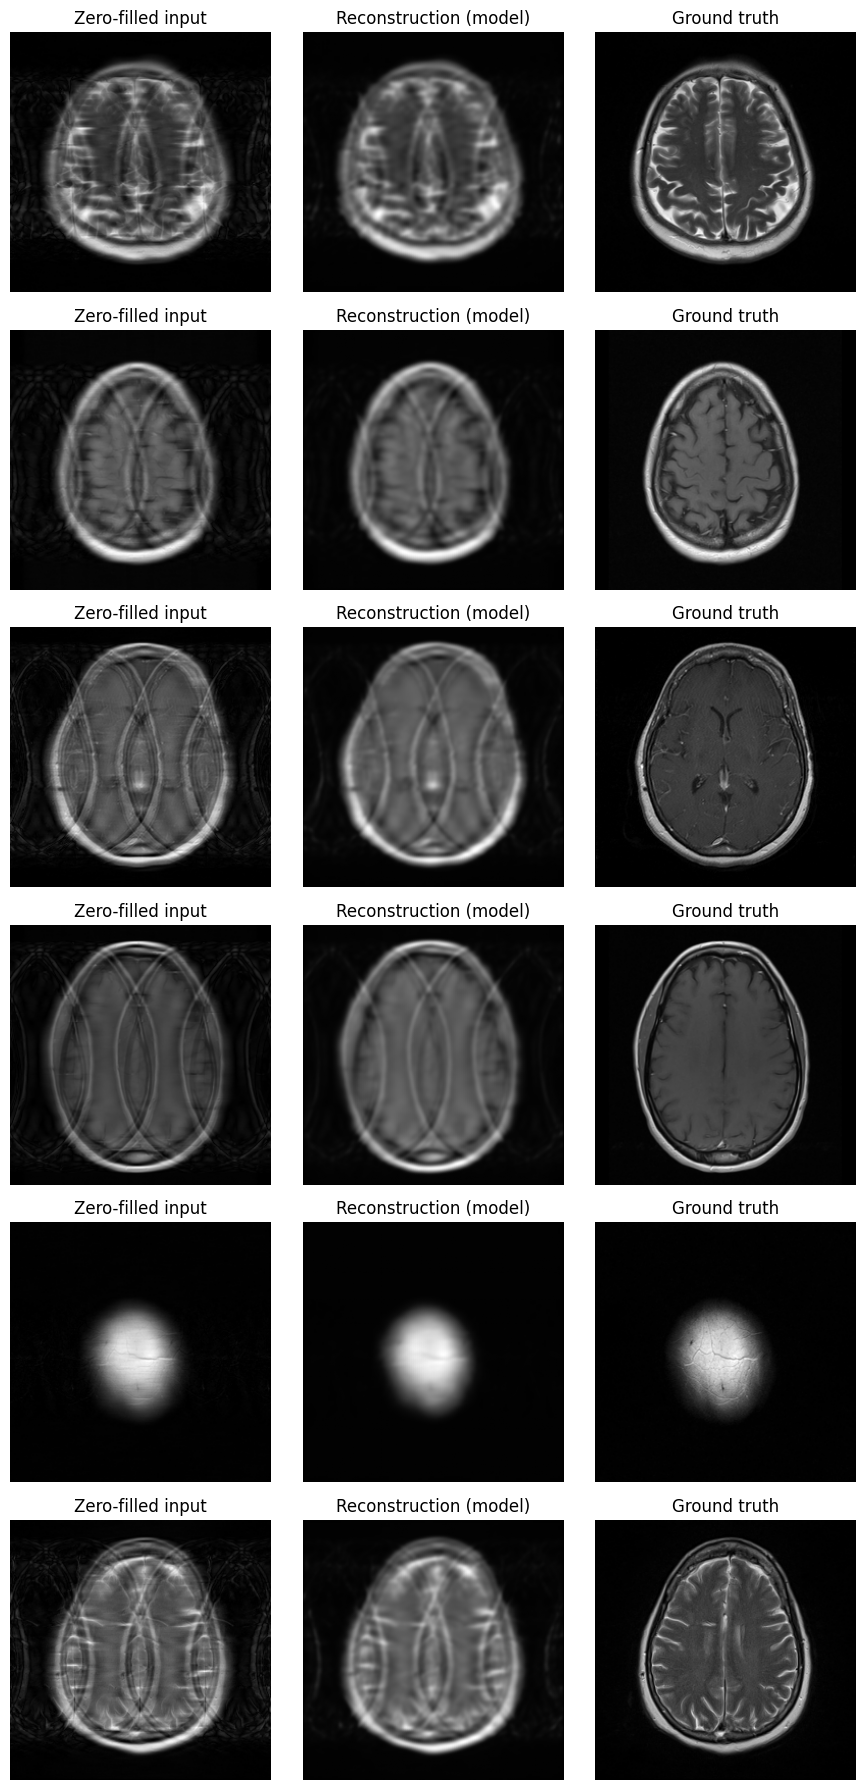

Saved global model to /content/global_recon_model.pth


In [19]:
# 10. Final evaluation & visualizations
# -------------------------
print("\nFinal evaluation on held-out test set:")
final_loss, final_psnr = evaluate_model(global_model, test_loader, DEVICE)
print(f" Final Test MSE: {final_loss:.6f}, PSNR: {final_psnr:.2f} dB")

# Visualize a few test reconstructions
num_show = min(6, len(test_loader.dataset))
fig, axs = plt.subplots(num_show, 3, figsize=(9, 3 * num_show))
k = 0
for xb, yb in test_loader:
    xb = xb.to(DEVICE); yb = yb.to(DEVICE)
    with torch.no_grad():
        pred = global_model(xb)
    xb = xb.cpu().numpy(); yb = yb.cpu().numpy(); pred = pred.cpu().numpy()
    B = xb.shape[0]
    for i in range(B):
        if k >= num_show: break
        axs[k,0].imshow(xb[i,0], cmap='gray'); axs[k,0].set_title("Zero-filled input")
        axs[k,1].imshow(pred[i,0], cmap='gray'); axs[k,1].set_title("Reconstruction (model)")
        axs[k,2].imshow(yb[i,0], cmap='gray'); axs[k,2].set_title("Ground truth")
        for a in axs[k]:
            a.axis('off')
        k += 1
    if k >= num_show: break
plt.tight_layout()
plt.show()

# Save the final global model (optional)
torch.save(global_model.state_dict(), "/content/global_recon_model.pth")
print("Saved global model to /content/global_recon_model.pth")